## Logistic Regression
---

This notebook fits a Logistic Regression model to the Scania Trucks Air Pressure System (APS) predictive maintenance dataset, obtained from [UCI's data repository](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks). 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import auc, roc_curve, precision_recall_curve, make_scorer, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

sns.set()

### Loading Data

In [3]:
df_train = pd.read_csv(r'./data/aps_failure_training_set_data_only.csv')

### Misclassification Cost Function

The dataset comes with a pre-defined challenge metric, shown below:

Cost of Misclassification = 10*(False Positive) + 500*(False Negative)

This cost will be used in lieu of traditional metrics, such as accuracy and/or AUROC/AUPR. 

In [4]:
def calc_misclassification_cost(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return 10*fp + 500*fn


misclassification_cost = make_scorer(
    calc_misclassification_cost,
    greater_is_better=False,
    needs_proba=False,
    needs_threshold=False
)

### Strategy
__SCALING & NaN VALUES__

Two strategies will be employed with regards to scaling & NaN values: 

* StandardScaler + Impute NaN values with mean of the column

* MinMaxScaler + Impute NaN values with 0, -1 (as in some columns, 0 already exists as a value), the column mode

<br>

A qualitative assessment will be that the StandardScaler method will not work well due to the amount of NaN values in all of the features. 

The StandardScaler relies on the mean of the column to shift the data, which will be skewed toward the value that NaNs are filled with. 

One solution is to impute the NaN values with the mean of the column, however, this may not be accurate as some features represent things such as ON/OFF, where an NaN value would be "OFF" (sensor is not gathering data unless something occurs, in which case, the sensor will measure some quantity). 

<br>
<br>

__IMBALANCED CLASSES__

Two strategies will be employed to combat class imbalance in the dataset:

* Sampling - Synthetic Minority Oversampling Technique (SMOTE)

* Class Weights - Weigh positive class misclassfications more heavily than negative class misclassifications.

### Grid Search Over All Strategies

This can also be considered a Full Factorial Design of Experiments (DOE) as the hyperparameter optimization also includes experimenting with data scalers, filling NaN values, and data sampling (e.g., not just optimizing hyperparameters, but also optimizing preprocessing steps).

In [5]:
# df --> X_train & y_train
X_train = df_train.drop('class', axis=1)
y_train = df_train['class']

In [21]:
# View Class Weights
compute_class_weight(class_weight='balanced', classes=['neg', 'pos'], y=y_train)

array([ 0.50847458, 30.        ])

In [13]:
# Run all combinations (e.g. Full Factorial)
fill_na = [0, -1, -100, -10_000, -1_000_000, 'mean', 'most_frequent']
scalers = ['minmax', 'maxabs', 'standard']
imbalance = [None, 'smote']
weights = [None, 'balanced']

s = [fill_na, scalers, imbalance, weights]
df_full_fact = pd.DataFrame(list(product(*s)), columns=['fill_na', 'scaler', 'imbalance', 'weights'])

# Drop rows where StandardScaler is used with fill_na methods that are not equal to 'mean'
df_full_fact.drop(
    df_full_fact[(df_full_fact.scaler == 'standard') & (df_full_fact.fill_na != 'mean')].index,
    inplace=True
    )
df_full_fact.reset_index(inplace=True, drop=True)

display(df_full_fact)
print('Total number of runs = %i' % df_full_fact.shape[0])

,fill_na,scaler,imbalance,weights
0,0,minmax,None,None
1,0,minmax,None,balanced
2,0,minmax,smote,None
3,0,minmax,smote,balanced
4,0,maxabs,None,None
5,0,maxabs,None,balanced
6,0,maxabs,smote,None
7,0,maxabs,smote,balanced
8,-1,minmax,None,None
9,-1,minmax,None,balanced


Total number of runs = 60


In [11]:
def fit_sklearn_pipeline(srs, c_vals=[0.001, 0.1, 1, 10, 100, 1000, 10_000]):
    steps = []

    # IMPUTATION METHOD
    if type(srs.fill_na) == int:
        steps.append(('impute', SimpleImputer(strategy='constant', fill_value=srs.fill_na)))
    else:
        steps.append(('impute', SimpleImputer(strategy=srs.fill_na)))

    # SCALING METHOD
    if srs.scaler == 'minmax':
        steps.append(('scale', MinMaxScaler()))
    elif srs.scaler == 'maxabs':
        steps.append(('scale', MaxAbsScaler()))
    else:
        steps.append(('scale', StandardScaler()))

    # SMOTE & WEIGHTS
    if srs.imbalance == 'smote':
        steps.append(('smote', SMOTE(random_state=1)))
        steps.append(
            ('log_reg_cv', 
            LogisticRegressionCV(
                cv=5, 
                random_state=1, 
                Cs=c_vals, 
                max_iter=1000, 
                n_jobs=-1,
                scoring=misclassification_cost,
                class_weight=srs.weights))
            )
        pipe = imbPipeline(steps=steps)

    else:
        steps.append(
            ('log_reg_cv', 
            LogisticRegressionCV(
                cv=5, 
                random_state=1, 
                Cs=c_vals, 
                max_iter=1000,
                n_jobs=-1, 
                scoring=misclassification_cost,
                class_weight=srs.weights))
            )
        pipe = Pipeline(steps=steps)

    # FIT & PREDICT
    pipe.fit(X_train, y_train)

    return pipe

In [ ]:
%%time
results = []

for i, row in enumerate(df_full_fact.iterrows()):
    # Fit pipeline
    pipe = fit_sklearn_pipeline(row[1])

    # Calculate average misclassification cost over all KFolds, best C & coeffs
    cv_mean_cost = -pipe['log_reg_cv'].scores_['pos'].mean(axis=0).max()
    C = pipe['log_reg_cv'].C_[0]
    coeffs = pipe['log_reg_cv'].coef_

    # Append to results df
    results.append((*row[1].tolist(), cv_mean_cost, C, coeffs))
    
    # sklearn warnings cannot be suppressed when n_jobs > 1, thus, write results to text file to monitor runs
    with open(r'./logs/log_lr.txt', mode='a') as f:
        f.write('Results for Run #%i: Cost = %i, C = %i\n' % (i+1, cv_mean_cost, C))

# Create results dataframe
df_results = pd.DataFrame(results, columns=['fill_na', 'scaler', 'imbalance', 'weights', 'cv_mean_cost', 'C', 'coeffs'])
df_results.to_csv(r'./results/log_reg_tuning.csv', index=False)

# This cell takes ~45 mins to run on an M1 Max Macbook Pro - cell output deleted due to amount of sklearn warnings

In [10]:
df_results = pd.read_csv(r'./results/log_reg_tuning.csv').fillna('None')
df_results.sort_values(by='cv_mean_cost')[:10]

,fill_na,scaler,imbalance,weights,cv_mean_cost,C,coeffs
33,-1000000,minmax,None,balanced,10132.0,10.0,[[ 13.09768877 0.4303521 0.7694874 -0.0...
25,-10000,minmax,None,balanced,10144.0,10.0,[[ 18.20449074 0.66609054 0.67248801 -0.1...
37,-1000000,maxabs,None,balanced,10252.0,10.0,[[ 1.30126951e+01 4.05651564e-01 7.99064282e...
29,-10000,maxabs,None,balanced,10354.0,10.0,[[ 18.22105952 0.69588495 0.67554668 -0.1...
9,-1,minmax,None,balanced,10456.0,10.0,[[ 20.42281691 4.69355953 0.68476451 -0.1...
13,-1,maxabs,None,balanced,10456.0,10.0,[[ 20.42630581 4.67810202 0.68479538 -0.1...
17,-100,minmax,None,balanced,10476.0,10.0,[[ 19.42937772 1.83153965 0.64289083 -0.1...
21,-100,maxabs,None,balanced,10480.0,10.0,[[ 19.45004531 1.23068008 0.64381372 -0.1...
5,0,maxabs,None,balanced,10782.0,10.0,[[ 19.3436096 4.31995289 0.57458772 -0.1...
1,0,minmax,None,balanced,10784.0,10.0,[[ 19.34392145 4.334949 0.57473312 -0.1...


* The top 10 performing parameter sets all use a weighted loss function (weights = balanced), which makes sense as the dataset is highly imbalanced.

* None of the top 10 performing parameter sets use SMOTE, which means it did not seem to work well for this dataset.

* With regards to the fill_na method, it seems the best strategy is to offset the NaN values away from the rest of the data.

* The MinMax scaler slightly outperformed the MaxAbs scaler.

### Best Estimator - Plots

In [14]:
pipe = fit_sklearn_pipeline(df_full_fact.iloc[33], c_vals=[10])

In [12]:
cv_mean_cost = -pipe['log_reg_cv'].scores_['pos'].mean(axis=0).max()
print('Cross-Validated Cost: %i' % cv_mean_cost)

Cross-Validated Cost: 10132


In [38]:
def plot_roc_auc(y_true, y_pred, model_name, file_path, figsize=(10, 8)):
    # Create figure
    fig = plt.figure(figsize=figsize)

    # Calculate ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    area = auc(fpr, tpr)
    plt.title('ROC Curve | %s | AUC = %0.5f' % (model_name, area))
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

    # Save & close plot
    plt.plot(fpr, tpr)
    fig.savefig(file_path)
    plt.close(fig)

    return area


def plot_precision_recall_auc(y_true, y_pred, model_name, file_path, figsize=(10, 8)):
    # Create figure
    fig = plt.figure(figsize=figsize)

    # Calculate ROC Curve & AUC
    pr, rc, thresholds = precision_recall_curve(y_true, y_pred)
    area = auc(rc, pr)
    plt.title('Precision-Recall Curve | %s | AUC = %0.5f' % (model_name, area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # Save & close plot
    plt.plot(rc, pr)
    fig.savefig(file_path)
    plt.close(fig)

    return area

probs = pipe.predict_proba(X_train)

plot_roc_auc(y_train.replace({'neg': 0, 'pos': 1}), probs[:, 1], 'Logistic Regression', r'./results/log_reg_roc.jpg');
plot_precision_recall_auc(y_train.replace({'neg': 0, 'pos': 1}), probs[:, 1], 'Logistic Regression', r'./results/log_reg_pr.jpg');

![image](./results/log_reg_roc.jpg)
![image](./results/log_reg_pr.jpg)

### Best Estimator - Feature Importance
Coefficients from the Logistic Regression model provides a crude estimate of the importance of a feature.

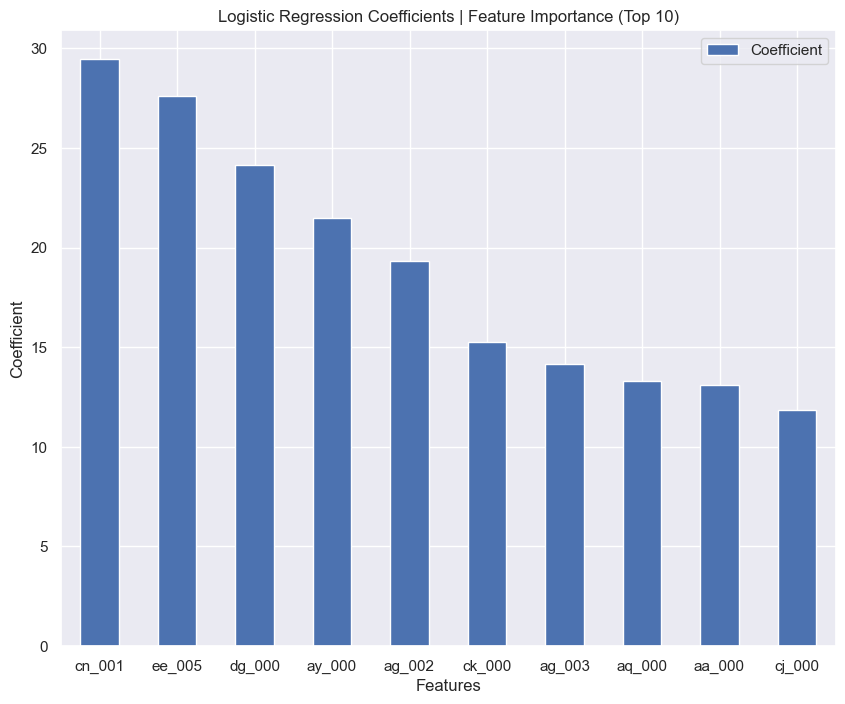

In [32]:
pd.DataFrame(zip(X_train.columns, pipe['log_reg_cv'].coef_[0]), columns=['Feature', 'Coefficient'])\
    .sort_values(by='Coefficient', ascending=False)[:10]\
    .plot(kind='bar', x='Feature', y='Coefficient', figsize=(10, 8), title='Logistic Regression Coefficients | Feature Importance (Top 10)', ylabel='Coefficient', xlabel='Features', rot=0);

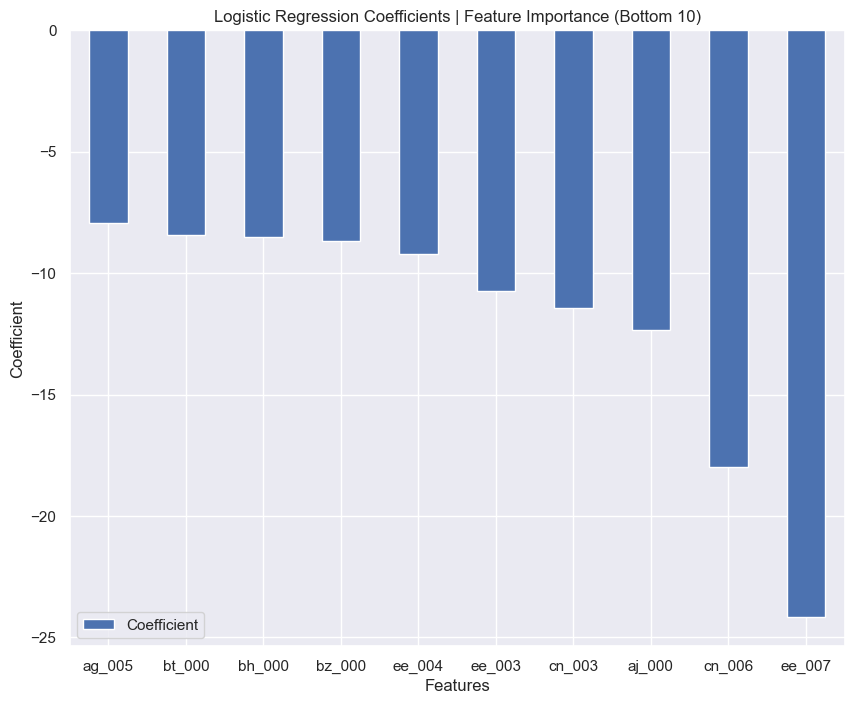

In [33]:
pd.DataFrame(zip(X_train.columns, pipe['log_reg_cv'].coef_[0]), columns=['Feature', 'Coefficient'])\
    .sort_values(by='Coefficient', ascending=False)[-10:]\
    .plot(kind='bar', x='Feature', y='Coefficient', figsize=(10, 8), title='Logistic Regression Coefficients | Feature Importance (Bottom 10)', ylabel='Coefficient', xlabel='Features', rot=0);

### Misclassification Cost on Test Set

In [37]:
df_test = pd.read_csv(r'./data/aps_failure_test_set_data_only.csv')

X_test = df_test.drop('class', axis=1)
y_test = df_test['class']
y_pred = pipe.predict(X_test)

print('Misclassification Cost on Test Data: %i' % calc_misclassification_cost(y_test, y_pred))

Misclassification Cost on Test Data: 15040


In [38]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Number of Type 1 Faults: %i' % fp)
print('Number of Type 2 Faults: %i' % fn)

Number of Type 1 Faults: 404
Number of Type 2 Faults: 22
